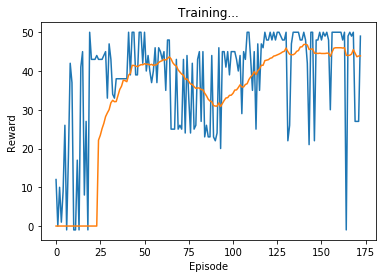

Episode 173 
 25 episode moving avg: 43.92


In [ ]:
# %matplotlib inline
import random
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from kingsheep_training import KingsheepEnv
from joschwa_training import KingsKeep
from simple_player import SimplePlayer
from config import FIELD_WIDTH, FIELD_HEIGHT

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display


class DQN(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()

        self.fc1 = nn.Linear(in_features=n_inputs, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=5)

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t


Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)


class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size


class EpsilonGreedyStrategy:
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)


class KingsheepEnvManager:
    def __init__(self, device, player1, player2, map_name):
        self.device = device
        self.player1 = player1
        self.player2 = player2
        self.map_name = map_name
        self.env = KingsheepEnv(player1=player1, player2=player1, map_name=map_name)
        self.done = False

    def reset(self):
        self.done = False
        self.env = KingsheepEnv(player1=self.player1, player2=self.player2, map_name=self.map_name)

    def step(self):
        iteration_summary, self.done = self.env.step()
        for k in iteration_summary.keys():
            for a in iteration_summary[k].keys():
                if a in {"state", "next_state"}:
                    iteration_summary[k][a] = KingsKeep.convert_field_to_state(field=iteration_summary[k][a],
                                                                              device=self.device,figure=k)
                else:
                    iteration_summary[k][a] = torch.tensor([iteration_summary[k][a]], device=self.device)

        return iteration_summary


def plot(values, moving_avg_period):
    if is_ipython: display.clear_output(wait=True)

    plt.figure(2)

    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)

    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.show()

    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])


def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period - 1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return t1, t2, t3, t4


class QValues:
    device = torch.device("cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]

        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values


batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 500


strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
device = torch.device("cpu")

input_size_sheep = 14
input_size_wolf = 14

sheep_policy_net = DQN(input_size_sheep).to(device)
sheep_optimizer = optim.Adam(params=sheep_policy_net.parameters(), lr=lr)

wolf_policy_net = DQN(input_size_wolf).to(device)
wolf_optimizer = optim.Adam(params=wolf_policy_net.parameters(), lr=lr)

sheep_target_net = DQN(input_size_sheep).to(device)
sheep_target_net.load_state_dict(sheep_policy_net.state_dict())
sheep_target_net.eval()

wolf_target_net = DQN(input_size_wolf).to(device)
wolf_target_net.load_state_dict(wolf_policy_net.state_dict())
wolf_target_net.eval()

sheep_memory = ReplayMemory(memory_size)
wolf_memory = ReplayMemory(memory_size)



player1 = KingsKeep(sheep_policy_net=sheep_policy_net,
                   wolf_policy_net=wolf_policy_net,
                   strategy=strategy,
                   device=device)
player2 = SimplePlayer()

is_p1_rl = True

map_name = r'/Users/johannschwabe/Documents/KingsKeep/training/resources/test.map'

em = KingsheepEnvManager(device=device, player1=player1, player2=player2, map_name=map_name)

episode_rewards = []
for episode in range(num_episodes):
    em.reset()
    episode_reward = 0

    while True:
        iteration_summary = em.step()

        if is_p1_rl:
            if 'sheep1' in iteration_summary:
                sheep_memory.push(Experience(iteration_summary['sheep1']['state'],
                                             iteration_summary['sheep1']['move'],
                                             iteration_summary['sheep1']['next_state'],
                                             iteration_summary['sheep1']['reward']))
                episode_reward += iteration_summary['sheep1']['reward']

            if 'wolf1' in iteration_summary:
                wolf_memory.push(Experience(iteration_summary['wolf1']['state'],
                                            iteration_summary['wolf1']['move'],
                                            iteration_summary['wolf1']['next_state'],
                                            iteration_summary['wolf1']['reward']))
                episode_reward += iteration_summary['wolf1']['reward']

        else:
            if 'sheep2' in iteration_summary:
                sheep_memory.push(Experience(iteration_summary['sheep2']['state'],
                                             iteration_summary['sheep2']['move'],
                                             iteration_summary['sheep2']['next_state'],
                                             iteration_summary['sheep2']['reward']))
                episode_reward += iteration_summary['sheep2']['reward']

            if 'wolf2' in iteration_summary:
                wolf_memory.push(Experience(iteration_summary['wolf2']['state'],
                                            iteration_summary['wolf2']['move'],
                                            iteration_summary['wolf2']['next_state'],
                                            iteration_summary['wolf2']['reward']))
                episode_reward += iteration_summary['wolf2']['reward']

        for memory, policy_net, target_net, optimizer in zip([sheep_memory, wolf_memory],
                                                             [sheep_policy_net, wolf_policy_net],
                                                             [sheep_target_net, wolf_target_net],
                                                             [sheep_optimizer, wolf_optimizer]):
            if memory.can_provide_sample(batch_size):
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)

                current_q_values = QValues.get_current(policy_net, states, actions)
                next_q_values = QValues.get_next(target_net, next_states)
                target_q_values = (next_q_values * gamma) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if em.done:
            episode_rewards.append(episode_reward)
            plot(episode_rewards, 25)
            break

    if episode % target_update == 0:
        for policy_net, target_net in zip([sheep_policy_net, wolf_policy_net],
                                          [sheep_target_net, wolf_target_net]):
            target_net.load_state_dict(policy_net.state_dict())

torch.save(sheep_policy_net.state_dict(), 'rlplayer_sheep_model.pt')
torch.save(wolf_policy_net.state_dict(), 'rlplayer_wolf_model.pt')
